In [1]:
import gudhi as gd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pickle

from matplotlib.pyplot import figure

from pygenstability import plotting
from pygenstability.optimal_scales import *
from pygenstability.pygenstability import evaluate_NVI

In [2]:
import sys
from pathlib import Path

module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

from msfiltration import MSF

In [3]:
root_fig = '/home/tc/OneDrive/Software/MSFiltration/figures/'

In [4]:
plt.rcParams.update({'font.size': 20})

# Generate multiscale SBM

In [5]:
from scipy.linalg import block_diag

[Text(0.5, 1.0, 'Coarse scale, n=3')]

<Figure size 432x288 with 0 Axes>

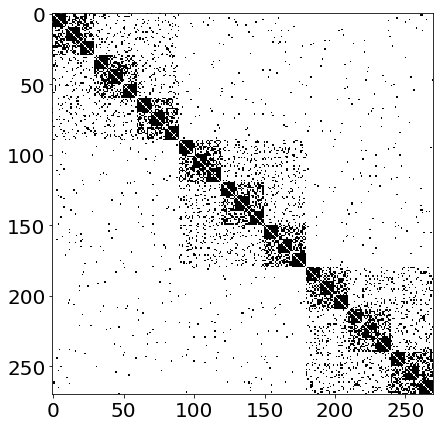

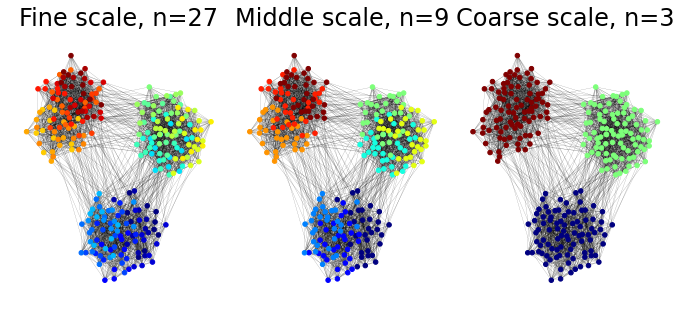

In [6]:
def block(n, th, rng):
    A = rng.uniform(0, 1, (n, n))
    A[A < th] = 0.0
    A[A > th] = 1.0
    A = (A + A.T) / 2
    return A


# define size and strength of multiscale structure
n0 = 270
th0 = 0.995

n1 = 3
th1 = 0.95

n2 = 9
th2 = 0.8

n3 = 27
th3 = 0.2

# construct adjacency matrix
rng = np.random.RandomState(42)
A = block(n0, th0, rng)
A += block_diag(*[block(int(n0 / n1), th1, rng) for i in range(n1)])
A += block_diag(*[block(int(n0 / n2), th2, rng) for i in range(n2)])
A += block_diag(*[block(int(n0 / n3), th3, rng) for i in range(n3)])

# binarized
A[A > 0] = 1

# remove self-loops
A -= np.diag(np.diag(A))

# plot matrix
plt.figure()
figure(figsize=(8, 7))
plt.imshow(A, interpolation="nearest",cmap='binary')
plt.savefig(root_fig +'SBM_adjacency_matrix.pdf', bbox_inches='tight')

# Multiscale structure
coarse_scale_id = np.zeros(n0)
middle_scale_id = np.zeros(n0)
fine_scale_id = np.zeros(n0)

for i in range(n1):
    coarse_scale_id[(i * n0 // n1) : ((i + 1) * n0 // n1)] = i

for i in range(n2):
    middle_scale_id[(i * n0 // n2) : ((i + 1) * n0 // n2)] = i

for i in range(n3):
    fine_scale_id[(i * n0 // n3) : ((i + 1) * n0 // n3)] = i

# Create nx graph
G = nx.from_numpy_array(A)

# Compute spring layout
pos = nx.layout.spring_layout(G, seed=2)

# Plot multiscale graph structure
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
fig.subplots_adjust(hspace=0.4, wspace=0)


nx.draw(
    G,
    ax=axes[0],
    pos=pos,
    node_size=20,
    arrows=False,
    width=0.1,
    node_color=fine_scale_id,
    cmap="jet",
)
axes[0].set(title=r"Fine scale, n=27")

nx.draw(
    G,
    ax=axes[1],
    pos=pos,
    node_size=20,
    arrows=False,
    width=0.1,
    node_color=middle_scale_id,
    cmap="jet",
)
axes[1].set(title=r"Middle scale, n=9")

nx.draw(
    G,
    ax=axes[2],
    pos=pos,
    node_size=20,
    arrows=False,
    width=0.1,
    node_color=coarse_scale_id,
    cmap="jet",
)
axes[2].set(title=r"Coarse scale, n=3")

#plt.savefig(root_fig +'Multiscale_Structure.pdf', dpi=fig.dpi,bbox_inches='tight')

In [7]:
print(G)

Graph with 270 nodes and 3473 edges


# Markov Stability filtration - full OOP framework


In [8]:
# Set MS parameters
n_scale = 200
min_scale = -1.5
max_scale = 0.5

In [9]:
# initialise MSF object
msf = MSF()

# run MS analysis, build filtration and compute PH
msf.fit_transform(A,min_scale,max_scale,n_scale,with_ttprime=True,with_optimal_scales=True)

Running Markov Stability analysis ... 


100%|██████████| 200/200 [00:38<00:00,  5.16it/s]


Building filtration ...


100%|██████████| 200/200 [00:07<00:00, 28.23it/s]


Computing persistence ... 


filtration took 3:14

# Results from Markov Stability analysis

In [10]:
all_results = msf.ms_results

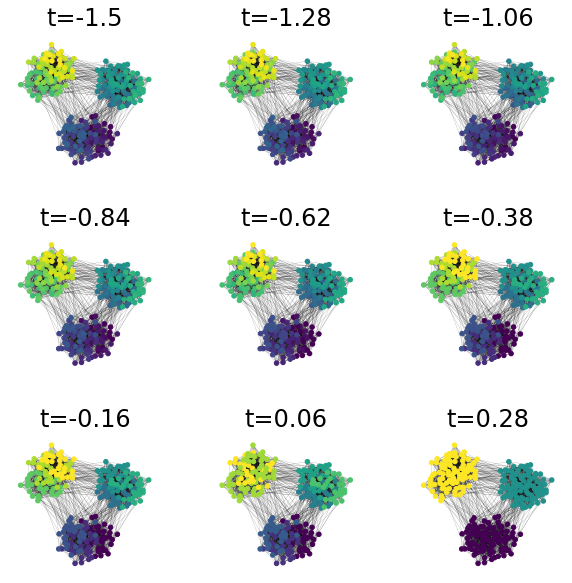

In [11]:
# Get scales
scales = all_results['scales']
log_scales = np.log10(all_results['scales'])
n_scale = all_results["run_params"]["n_scale"]

# Get information about communities
community_id = all_results['community_id']
n_communities  = all_results['number_of_communities']

fig, axes = plt.subplots(3, 3, figsize=(10,10))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

for i, ax in enumerate(axes.flat):
    
    scale = int(i*len(scales)/9)
    
    nx.draw(G, ax=ax,pos=pos, node_size = 20, arrows=False, width = 0.1,
            node_color = community_id[scale])
    ax.set(title=r't={}'.format(np.around(log_scales[scale],2)))
plt.show()

[-0.77638191 -0.2638191   0.37939698]


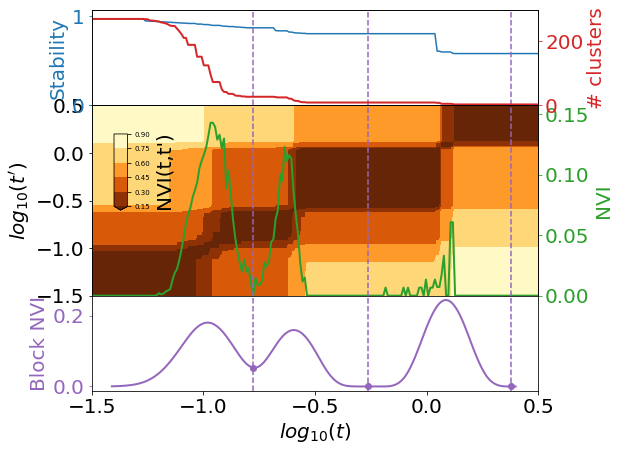

In [37]:
# select optimal scales
identify_optimal_scales(all_results,kernel_size=30,window_size=20)
selected_scales = log_scales[all_results['selected_partitions']]
print(selected_scales)

figure(figsize=(8, 7))
plotting.plot_scan(all_results)
plt.savefig(root_fig +'SBM_MS_Scan.pdf',bbox_inches='tight')

In [13]:
selected_paritions = all_results['selected_partitions']

n_communities = [len(np.unique(all_results['community_id'][i])) for i in range(len(scales))]

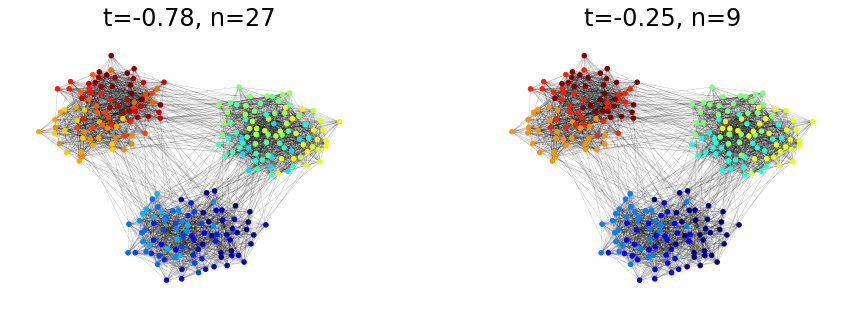

In [14]:
fig, axes = plt.subplots(1, len(selected_paritions), figsize=(15,5))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

for i, ax in enumerate(axes.flat):
    
    scale = selected_paritions[i]
    
    nx.draw(G, ax=ax,pos=pos, node_size = 20, arrows=False, width = 0.1,
            node_color = community_id[scale],cmap = 'jet')
    ax.set(title=r't={}, n={}'.format(np.around(log_scales[scale],2), n_communities[scale]))

#plt.savefig(root_fig +'Partitions_ScaleCrit.pdf', dpi=fig.dpi,bbox_inches='tight')

In [15]:
from pygenstability.contrib.sankey import plot_sankey

In [16]:
all_results['selected_partitions']

[72, 124]

In [17]:
# Hack to plot Sankey
all_results['selected_partitions'] = [35,40,51,62,80,104,150]
s = plot_sankey(all_results,optimal_scales=True,live=False)
s.write_image(root_fig +"SBM_Sankey.pdf", format='pdf')

# Persistent homology - gap based scale selection

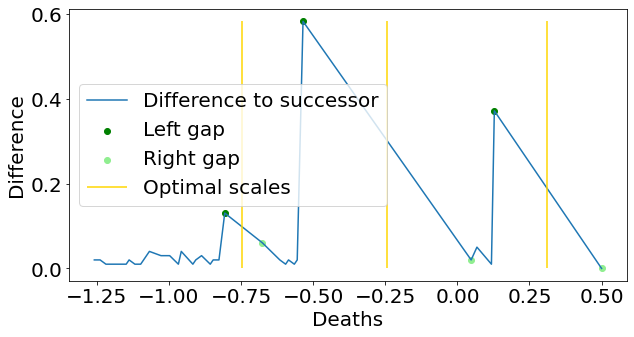

array([ 75, 125, 180])

In [47]:
# Select optimal scales
msf.select_scales(threshold_abs=0.13,min_gap_width=0.13,with_plot=True)
msf.optimal_scales

<Figure size 504x504 with 0 Axes>

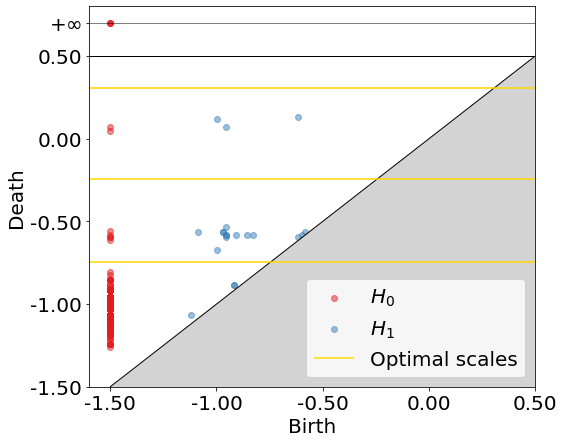

In [48]:
# Plot persistence diagram with optimal scales

figure(figsize=(7, 7))
msf.plot_persistence_diagram()
plt.savefig(root_fig +'SBM_PD.pdf',bbox_inches='tight')

In [49]:
msf.filtration.persistence(homology_coeff_field=2)

[(1, (-0.9974874371859297, 0.11809045226130661)),
 (1, (-0.957286432160804, 0.0678391959798996)),
 (1, (-0.6155778894472361, 0.12814070351758786)),
 (1, (-1.0879396984924623, -0.5653266331658291)),
 (1, (-0.957286432160804, -0.535175879396985)),
 (1, (-0.9673366834170855, -0.5653266331658291)),
 (1, (-0.9673366834170855, -0.5653266331658291)),
 (1, (-0.957286432160804, -0.585427135678392)),
 (1, (-0.957286432160804, -0.585427135678392)),
 (1, (-0.957286432160804, -0.5954773869346733)),
 (1, (-0.9974874371859297, -0.6758793969849246)),
 (1, (-0.907035175879397, -0.585427135678392)),
 (1, (-0.8567839195979898, -0.585427135678392)),
 (1, (-0.8266331658291457, -0.585427135678392)),
 (1, (-1.1180904522613067, -1.0678391959798996)),
 (1, (-0.9170854271356784, -0.8869346733668342)),
 (1, (-0.9170854271356784, -0.8869346733668342)),
 (1, (-0.585427135678392, -0.5653266331658291)),
 (1, (-0.6155778894472361, -0.5954773869346733)),
 (1, (-0.5954773869346733, -0.585427135678392)),
 (0, (-1.5, inf

In [50]:
np.argwhere(msf.persistence[3][1][1]==msf.log_scales)[0][0]

93

In [51]:
msf.persistence

[(1, (-0.9974874371859297, 0.11809045226130661)),
 (1, (-0.957286432160804, 0.0678391959798996)),
 (1, (-0.6155778894472361, 0.12814070351758786)),
 (1, (-1.0879396984924623, -0.5653266331658291)),
 (1, (-0.957286432160804, -0.535175879396985)),
 (1, (-0.9673366834170855, -0.5653266331658291)),
 (1, (-0.9673366834170855, -0.5653266331658291)),
 (1, (-0.957286432160804, -0.585427135678392)),
 (1, (-0.957286432160804, -0.585427135678392)),
 (1, (-0.957286432160804, -0.5954773869346733)),
 (1, (-0.9974874371859297, -0.6758793969849246)),
 (1, (-0.907035175879397, -0.585427135678392)),
 (1, (-0.8567839195979898, -0.585427135678392)),
 (1, (-0.8266331658291457, -0.585427135678392)),
 (1, (-1.1180904522613067, -1.0678391959798996)),
 (1, (-0.9170854271356784, -0.8869346733668342)),
 (1, (-0.9170854271356784, -0.8869346733668342)),
 (1, (-0.585427135678392, -0.5653266331658291)),
 (1, (-0.6155778894472361, -0.5954773869346733)),
 (1, (-0.5954773869346733, -0.585427135678392)),
 (0, (-1.5, inf

In [52]:
for i in range(len(msf.persistence)):
    try:
        print(msf.persistence[i][0],
            np.argwhere(msf.persistence[i][1][0]==msf.log_scales)[0][0],
            np.argwhere(msf.persistence[i][1][1]==msf.log_scales)[0][0])
    except:
        pass

1 50 161
1 54 156
1 88 162
1 41 93
1 54 96
1 53 93
1 53 93
1 54 91
1 54 91
1 54 90
1 50 82
1 59 91
1 64 91
1 67 91
1 38 43
1 58 61
1 58 61
1 91 93
1 88 90
1 90 91
0 0 156
0 0 154
0 0 94
0 0 91
0 0 90
0 0 90
0 0 88
0 0 69
0 0 67
0 0 65
0 0 64
0 0 64
0 0 64
0 0 64
0 0 61
0 0 61
0 0 61
0 0 59
0 0 59
0 0 59
0 0 59
0 0 59
0 0 59
0 0 59
0 0 58
0 0 58
0 0 58
0 0 58
0 0 58
0 0 58
0 0 58
0 0 58
0 0 58
0 0 58
0 0 58
0 0 58
0 0 58
0 0 58
0 0 58
0 0 58
0 0 58
0 0 58
0 0 58
0 0 58
0 0 58
0 0 58
0 0 58
0 0 58
0 0 54
0 0 54
0 0 54
0 0 54
0 0 54
0 0 54
0 0 54
0 0 54
0 0 54
0 0 54
0 0 54
0 0 54
0 0 54
0 0 54
0 0 54
0 0 54
0 0 54
0 0 54
0 0 54
0 0 54
0 0 54
0 0 54
0 0 54
0 0 54
0 0 54
0 0 54
0 0 53
0 0 53
0 0 53
0 0 53
0 0 53
0 0 53
0 0 53
0 0 53
0 0 53
0 0 53
0 0 53
0 0 53
0 0 53
0 0 53
0 0 53
0 0 53
0 0 53
0 0 53
0 0 53
0 0 53
0 0 53
0 0 53
0 0 53
0 0 53
0 0 53
0 0 53
0 0 53
0 0 53
0 0 53
0 0 53
0 0 50
0 0 50
0 0 50
0 0 50
0 0 50
0 0 50
0 0 50
0 0 50
0 0 50
0 0 50
0 0 50
0 0 50
0 0 50
0 0 50
0 0 50
0 

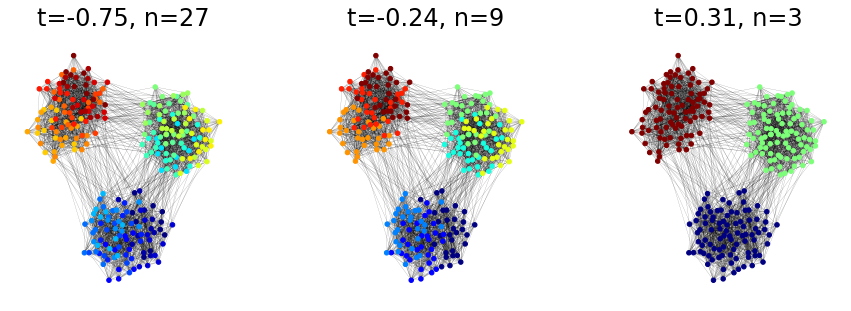

In [53]:
fig, axes = plt.subplots(1, len(msf.optimal_scales), figsize=(15,5))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

for i, ax in enumerate(axes.flat):
    
    scale = msf.optimal_scales[i] 
    
    nx.draw(G, ax=ax,pos=pos, node_size = 20, arrows=False, width = 0.1,
            node_color = community_id[scale],cmap = 'jet')
    ax.set(title=r't={}, n={}'.format(np.around(log_scales[scale],2), n_communities[scale]))

#plt.savefig(root_fig +'Partitions_PH.pdf', dpi=fig.dpi,bbox_inches='tight')

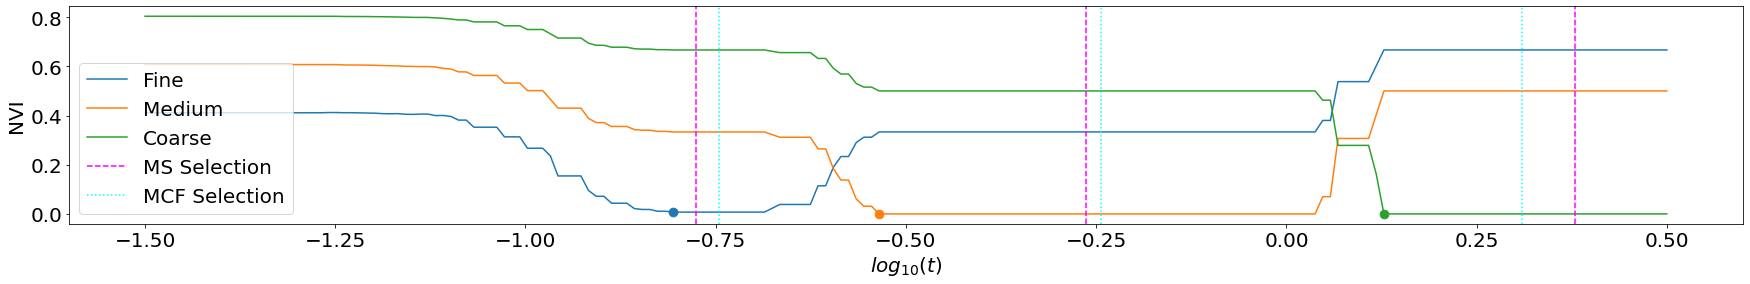

In [54]:
# compare MS partitions to ground truth with NVI
NVI_scores_fine = np.array(
    [
        evaluate_NVI([0, i], [fine_scale_id] + all_results["community_id"])
        for i in range(1, n_scale + 1)
    ]
)
NVI_scores_middle = np.array(
    [
        evaluate_NVI([0, i], [middle_scale_id] + all_results["community_id"])
        for i in range(1, n_scale + 1)
    ]
)
NVI_scores_coarse = np.array(
    [
        evaluate_NVI([0, i], [coarse_scale_id] + all_results["community_id"])
        for i in range(1, n_scale + 1)
    ]
)



# # plot lower bound
fig, ax = plt.subplots(1, figsize=(30, 4))
# ax.axhline(0, c="k", ls="--")

# plot NVI scores
ax.plot(log_scales, NVI_scores_fine, label="Fine")
ax.plot(log_scales, NVI_scores_middle, label="Medium")
ax.plot(log_scales, NVI_scores_coarse, label="Coarse")

# plot minima of NVI scores
ax.scatter(
    log_scales[np.argmin(NVI_scores_fine)], NVI_scores_fine.min(), marker=".", s=300
)
ax.scatter(
    log_scales[np.argmin(NVI_scores_middle)],
    NVI_scores_middle.min(),
    marker=".",
    s=300,
)
ax.scatter(
    log_scales[np.argmin(NVI_scores_coarse)],
    NVI_scores_coarse.min(),
    marker=".",
    s=300,
)


for i in range(len(selected_scales)):
    if i == 0:
        ax.axvline(
            x=selected_scales[i],
            ls="--",
            color="Magenta",
            label="MS Selection",
        )
    else:
        ax.axvline(x=selected_scales[i], ls="--", color="Magenta")

for i in range(len(msf.optimal_scales)):
    if i == 0:
        ax.axvline(
            x=log_scales[msf.optimal_scales[i]],
            ls=":",
            color="Cyan",
            label="MCF Selection",
        )
    else:
        ax.axvline(x=log_scales[msf.optimal_scales[i]], ls=":", color="Cyan")

ax.set(xlabel=r"$log_{10}(t)$", ylabel="NVI")  # yticks = [0.2,0.4,0.6,0.8] )

ax.legend(loc=3)

plt.savefig(root_fig +'SBM_NVI_Comparison.pdf', dpi=fig.dpi,bbox_inches='tight')

# Persistent homology - density based scale selection

In [26]:
from msfiltration.msf_properties import compute_combined_birth_count, compute_combined_death_count
from msfiltration.scale_selection import select_scales_density

In [27]:
death_count = compute_combined_death_count(msf,[1,2])
birth_count = compute_combined_birth_count(msf,[0,1,2])

In [28]:
# compute death density
death_total = np.sum(death_count)
death_density = death_count / death_total

# compute birth density
birth_total = np.sum(birth_count)
birth_density = birth_count / birth_total

In [29]:
import ruptures as rpt

In [30]:
points = np.cumsum(death_density[:-1])

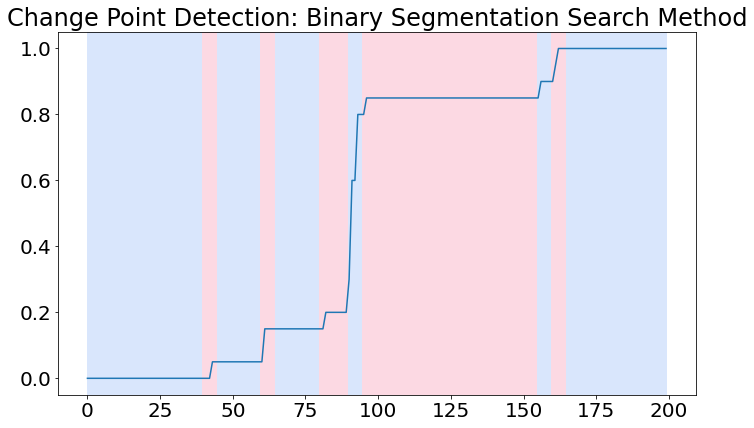

In [31]:
#Changepoint detection with the Binary Segmentation search method
model = "l2"  
algo = rpt.Binseg(model=model).fit(points)
my_bkps = algo.predict(n_bkps=10)
# show results
rpt.show.display(points, my_bkps, figsize=(10, 6))
plt.title('Change Point Detection: Binary Segmentation Search Method')
plt.show()

In [32]:
my_bkps

[40, 45, 60, 65, 80, 90, 95, 155, 160, 165, 200]

<AxesSubplot:xlabel='Birth', ylabel='Death'>

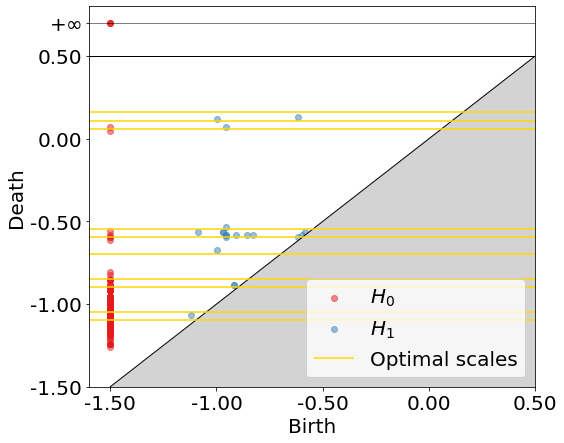

In [33]:
msf.optimal_scales = my_bkps[:-1]
msf.plot_persistence_diagram()

In [38]:
# # compare MS partitions to ground truth with NVI
# NVI_scores_fine = np.array(
#     [
#         _evaluate_NVI([0, i], [fine_scale_id] + all_results["community_id"])
#         for i in range(1, n_scale + 1)
#     ]
# )
# NVI_scores_middle = np.array(
#     [
#         _evaluate_NVI([0, i], [middle_scale_id] + all_results["community_id"])
#         for i in range(1, n_scale + 1)
#     ]
# )
# NVI_scores_coarse = np.array(
#     [
#         _evaluate_NVI([0, i], [coarse_scale_id] + all_results["community_id"])
#         for i in range(1, n_scale + 1)
#     ]
# )



# # plot lower bound
# fig, ax = plt.subplots(1, figsize=(15, 3.5))
# ax.axhline(0, c="k", ls="--")

# # plot NVI scores
# ax.plot(log_scales, NVI_scores_fine, label="Fine planted scale")
# ax.plot(log_scales, NVI_scores_middle, label="Middle planted scale")
# ax.plot(log_scales, NVI_scores_coarse, label="Coarse planted scale")

# # plot minima of NVI scores
# ax.scatter(
#     log_scales[np.argmin(NVI_scores_fine)], NVI_scores_fine.min(), marker=".", s=300
# )
# ax.scatter(
#     log_scales[np.argmin(NVI_scores_middle)],
#     NVI_scores_middle.min(),
#     marker=".",
#     s=300,
# )
# ax.scatter(
#     log_scales[np.argmin(NVI_scores_coarse)],
#     NVI_scores_coarse.min(),
#     marker=".",
#     s=300,
# )


# # for i in range(len(selected_scales)):
# #     if i == 0:
# #         ax.axvline(
# #             x=selected_scales[i],
# #             ls="--",
# #             color="purple",
# #             label="NVI Optimal Scales",
# #         )
# #     else:
# #         ax.axvline(x=selected_scales[i], ls="--", color="purple")

# for i in range(len(msf.optimal_scales)):
#     if i == 0:
#         ax.axvline(
#             x=log_scales[msf.optimal_scales[i]],
#             ls="--",
#             color="gold",
#             label="MSF Optimal Scales",
#         )
#     else:
#         ax.axvline(x=log_scales[msf.optimal_scales[i]], ls="--", color="gold")

# ax.set(xlabel=r"$log_{10}(t)$", ylabel="NVI")  # yticks = [0.2,0.4,0.6,0.8] )

# ax.legend(loc=3)

# #plt.savefig(root_fig +'NVI_Comparison.pdf', dpi=fig.dpi,bbox_inches='tight')

# Analyse hierarchy of partitions using $\beta_0$

In [39]:
from msfiltration.msf_properties import compute_rank, compute_beta_0

In [40]:
%load_ext autoreload
%autoreload 2

In [41]:
rank = compute_rank(msf)
beta_0 = compute_beta_0(msf)

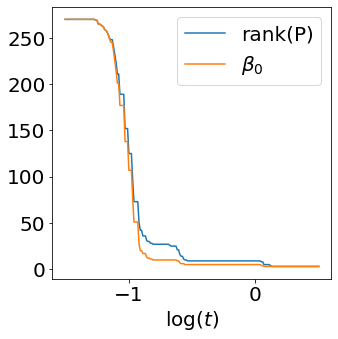

In [42]:
fig, ax = plt.subplots(1, figsize=(5, 5))
ax.plot(msf.log_scales,rank, label = 'rank(P)')
ax.plot(msf.log_scales,beta_0[:-1], label = r'$\beta_0$')
ax.set(xlabel=r'$\log(t)$')
ax.legend()
#plt.show()
plt.savefig(root_fig +'SBM_beta0.pdf', dpi=fig.dpi,bbox_inches='tight')

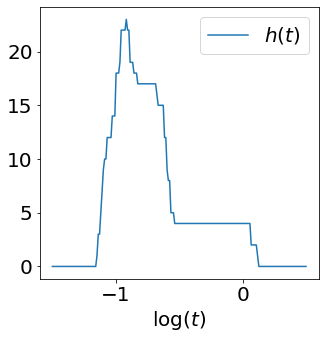

In [43]:
fig, ax = plt.subplots(1, figsize=(5, 5))
ax.plot(msf.log_scales,(rank-beta_0[:-1]), label = r'$h(t)$')
ax.set(xlabel=r'$\log(t)$')
ax.legend()
#plt.savefig(root_fig +'SBM_persistent_hierarchy.pdf', dpi=fig.dpi,bbox_inches='tight')
plt.show()

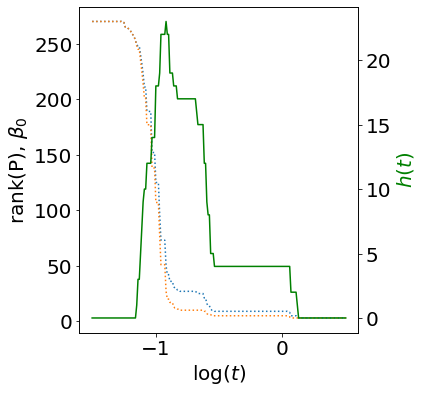

In [44]:
fig, ax1 = plt.subplots(1, figsize=(5, 6))
ax1.plot(msf.log_scales,rank, label = 'rank(P)',ls=':')
ax1.plot(msf.log_scales,beta_0[:-1], label = r'$\beta_0$',ls=':')
ax1.set(xlabel=r'$\log(t)$',ylabel=r'rank(P), $\beta_0$')
handles1, labels = plt.gca().get_legend_handles_labels()
ax2 = ax1.twinx()
ax2.plot(msf.log_scales,(rank-beta_0[:-1]), label = r'$h(t)$',c='green')
ax2.set_ylabel(r'$h(t)$', color="green")
#ax2.tick_params("y", colors="green")
handles2, labels = plt.gca().get_legend_handles_labels()
# ax.legend()
# ax2.legend()
#plt.legend(handles=handles1+handles2)
#plt.show()
#plt.savefig(root_fig +'SBM_persistent_hierarchy.pdf', dpi=fig.dpi,bbox_inches='tight')

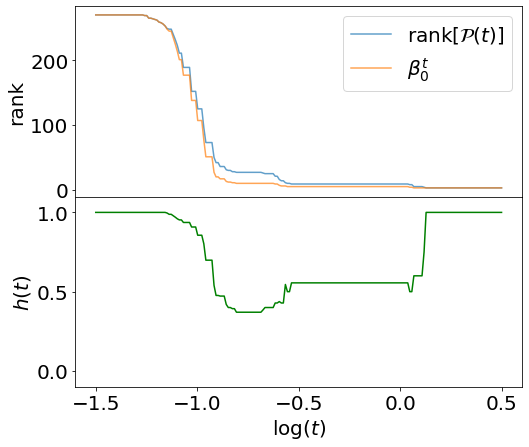

In [45]:
fig, axs = plt.subplots(2, figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.3)
ax1 = axs[0]
ax2 = axs[1]
ax1.plot(msf.log_scales,rank, label = r'rank$[\mathcal{P}(t)]$',alpha=0.7)#,ls=':')
ax1.plot(msf.log_scales,beta_0[:-1], label = r'$\beta_0^t$',alpha=0.7)#,ls=':')
ax1.set(xticks=[],ylabel=r'rank')

ax1.legend()

ax2.plot(msf.log_scales,beta_0[:-1]/rank, label = r'$h(t)$',c='green')
ax2.set_ylabel(r'$h(t)$')#, color="green")
ax2.set(xlabel=r'$\log(t)$',ylim=(-0.1,1.1))
#ax2.legend()
plt.savefig(root_fig +'SBM_persistence_hierarchy.pdf', dpi=fig.dpi,bbox_inches='tight')